### Calculate and plot the seasonal climatology of Southern Ocean chlorophyll-a from GlobColour

In [7]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import utils.geo as geo
from dask.diagnostics import ProgressBar

In [8]:
import matplotlib as mpl
mpl.rcParams['font.size']=18
# mpl.rcParams['font.family']='serif'
# mpl.rcParams['font.serif']='Times'
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['legend.fontsize']=14

Note that this notebook makes use of my `utils` package, available [here](https://github.com/gmacgilchrist/utils)

## Working from processed globcolour data (daily, interpolated)
Processed in `calc_spatialmean_globcolour_daily.ipynb` and data saved here: `../../data/globcolour_cmems_daily_CHL_wmean-latlon_byyear-JULtoJUN.nc`

In [16]:
smooth = True
basins = False

In [17]:
dataset = 'globcolour'
frequency = 'day'
variable = 'CHL1'
yearstart = 1999
yearend = 2022
monthorder = 'JULtoJUN'
averaging = 'wmean-latlon'

outdir = '../../data/'
yearstr = str(yearstart)+'-'+str(yearend)
outpath = outdir+'.'.join([dataset,frequency,averaging,monthorder,yearstr,'nc'])

In [18]:
outpath

'../../data/globcolour.day.wmean-latlon.JULtoJUN.1999-2022.nc'

In [19]:
ds = xr.open_dataset(outpath)
smoothval = 14
if smooth:
    ds = ds.rolling(day=smoothval,center=True).mean()

In [20]:
ds

<xarray.Dataset>
Dimensions:  (year: 24, day: 365)
Coordinates:
  * year     (year) int64 1999 2000 2001 2002 2003 ... 2018 2019 2020 2021 2022
  * day      (day) int64 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364
Data variables:
    CHL1     (day, year) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [21]:
if basins:
    bs = xr.Dataset()
    for basin in ['epacific','wpacific','indian','atlantic']:
        outpath = '.'.join([prefix,averaging,monthorder,yearstr,basin,'nc'])
        bs[basin] = xr.open_dataarray(outpath)
    smooth = True
    smoothval = 14
    if smooth:
        bs = bs.rolling(day=smoothval,center=True).mean()
    anoms = bs.sel(year=2021)-bs.sel(year=slice(1998,2020)).mean('year')

NameError: name 'b1' is not defined

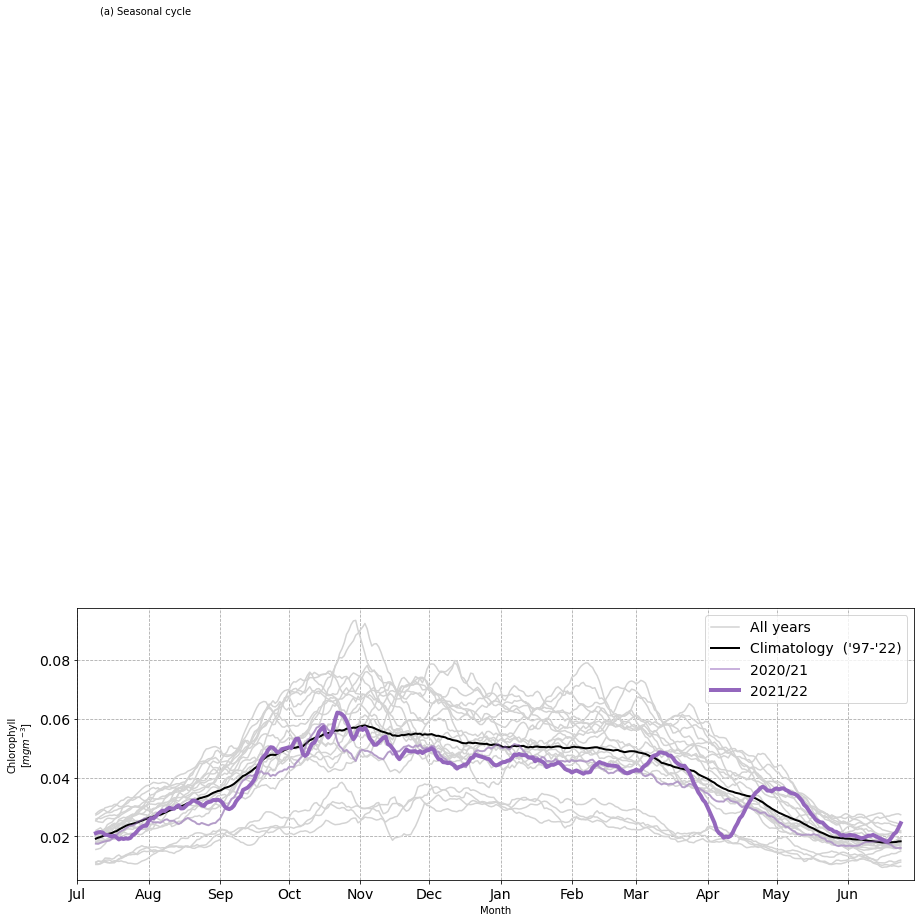

In [22]:
fig,ax = plt.subplots(figsize=(15,5))
# All years
for year in ds['year'][:-1]:
    h, = ax.plot(ds['day'],ds[variable].sel(year=year),color='lightgray',label='All years')
# Climatology
ds_clim = ds.sel(year=slice(1998,2023)).mean('year')
h1, = ax.plot(ds_clim['day'],ds_clim[variable],color='black',linewidth=2,label="Climatology  ('97-'22)")
# 2021
h2, = ax.plot(ds['day'],ds[variable].sel(year=2021),color='tab:purple',linewidth=2,alpha=0.5,label='2020/21')
# 2022
h3, = ax.plot(ds['day'],ds[variable].sel(year=2022),color='tab:purple',linewidth=4,label='2021/22')

monthname = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
monthlength = np.array([31,31,30,31,30,31,31,28,31,30,31,30])
monthday = np.append(np.array([0]),np.cumsum(monthlength))
ax.set_xticks(monthday[:-1])
ax.set_xticklabels(monthname)
ax.set_xlim(0,364)
ax.set_xlabel('Month')
ax.set_ylabel('Chlorophyll\n[$mgm^{-3}$]')#,rotation=0,ha='right',y=0.8)
ax.grid(linestyle='--',color='darkgray')

ax.text(10,0.3,'(a) Seasonal cycle')

l1 = ax.legend(handles=[h,h1,h2,h3],loc='upper right')

if basins:
    anomtot = ds[variable].sel(year=2021) - ds_clim[variable]
#     ax.plot(anomtot['day'],anomtot,color='k',linestyle='--')
    # Basin anomalies
    plot_kwargs = {'alpha':0.7}
    b1 = ax.fill_between(anoms['day'],anoms['atlantic'],label='Atlantic',**plot_kwargs)
    b2 = ax.fill_between(anoms['day'],anoms['indian'],label='Indian',**plot_kwargs)
    b3 = ax.fill_between(anoms['day'],anoms['wpacific'],label='W. Pacific',**plot_kwargs)
    b4 = ax.fill_between(anoms['day'],anoms['epacific'],label='E. Pacific',**plot_kwargs,color='tab:pink')

    ax.text(10,0.05,'(b) Anomalies')

ax.legend(handles=[b1,b2,b3,b4],loc='lower right')
ax.add_artist(l1)
# ax.legend(bbox_to_anchor=(1,1))

ax.axvspan(monthday[5],monthday[8], color='lightgray', alpha=0.2, lw=0, zorder=0)

savename = 'seasonal-climatology'+'.'.join([dataset,frequency,variable])
if smooth:
    savename = savename+'_smooth-'+str(smoothval)
if basins:
    savename = savename+'_basins'
fig.savefig('../../figures/'+savename+'.pdf',transparent=True)

## Working from raw globcolour (8-day) data

### Load data.

In [3]:
def preprocess(ds):
    time = pd.to_datetime(ds.attrs['start_time'])
    if 'CHL1_error' in ds.data_vars:
        ds = ds.drop(['CHL1_error'])
    return ds.sel({'lat':slice(-30,-65)}).expand_dims({'time':[time]})

rootdir = '/projects/SOCCOM/datasets/GlobColour/merged/8-day/'
mode = 'AV'
var = 'CHL1'

print('Opening.')
paths = glob.glob(rootdir+'*/*/*/*'+mode+'*'+var+'*.nc')
ds = xr.open_mfdataset(paths,preprocess=preprocess,use_cftime=False)
ds['time'] = pd.to_datetime(ds['time'].values)

Opening.


In [4]:
ds

<xarray.Dataset>
Dimensions:     (time: 1163, lat: 840, lon: 8640)
Coordinates:
  * time        (time) datetime64[ns] 1997-09-04T16:26:34 ... 2022-12-03T00:0...
  * lat         (lat) float32 -30.02 -30.06 -30.1 -30.15 ... -64.9 -64.94 -64.98
  * lon         (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    CHL1_mean   (time, lat, lon) float32 dask.array<chunksize=(1, 840, 8640), meta=np.ndarray>
    CHL1_flags  (time, lat, lon) float32 dask.array<chunksize=(1, 840, 8640), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour 8-day SeaWiFS product
    product_name:               L3m_19970829-19970905__GLOB_4_AV-SWF_CHL1_8D_...
    product_type:               8-day
    product_version:            2018.1
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20180504T101738Z: globcolour_l3_reproject.sh ...
    input_files:                S1997247162631.L2_GAC_OC.nc,S1997247162634.L2...
    input_files_reprocessings:  2018.0,2018.0

In [5]:
# Get area
ds,xgrid = geo.get_xgcm_horizontal(ds,axes_dims_dict={'X':'lon','Y':'lat'},periodic='X')
ds['area'] = ds['dxC']*ds['dyC']

### Average data.

In [ ]:
# Extract spatial average for each year
# Interpolate to each of 365 days
years = np.arange(1997,2002)
days = np.arange(1,367)
ds_year = xr.DataArray(dims=['day','year'],coords={'year':years,'day':days})
for i,year in enumerate(years):
    print(year)
    # Need to set nans to zero otherwise it ignores them in the average!
    xs = (ds.sel({'time':slice(str(year)+'-01-01',str(year)+'-12-31')}))
    x = xs['CHL1_mean'].fillna(0).where(xs['CHL1_flags']!=9,np.nan).weighted(ds['area'].fillna(0)).mean(['lat','lon'])
    fill_value=np.nan
    x_allyear = x.assign_coords({'time':x['time.dayofyear']}).interp({'time':days},kwargs={'fill_value': fill_value})
    with ProgressBar():
        ds_year.loc[{'year':year}]=x_allyear.values

1997
[########################################] | 100% Completed | 5.37 sms
1998
[########################################] | 100% Completed | 16.29 s
1999
[############################            ] | 71% Completed | 27.77 ss

### Plot data.

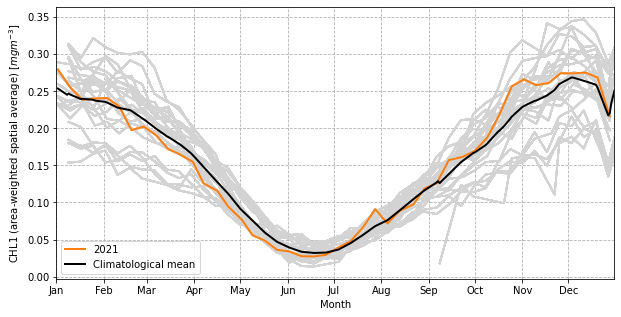

In [45]:
fig,ax = plt.subplots(figsize=(10,5))
# All years
for year in years[:-1]:
    ax.plot(ds_year['day'],ds_year,color='lightgray')
# 2021
ax.plot(ds_year['day'],ds_year.isel(year=-1),color='tab:orange',linewidth=2,label='2021')
# Climatology
ds_clim = ds_year.mean('year')
ax.plot(ds_year['day'],ds_clim,color='black',linewidth=2,label='Climatological mean')

monthname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthlength = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
monthday = np.append(np.array([0]),np.cumsum(monthlength))
ax.set_xticks(monthday[:-1])
ax.set_xticklabels(monthname)
ax.set_xlim(0,364)
ax.set_xlabel('Month')
ax.set_ylabel(var+' (area-weighted spatial average) [$mgm^{-3}$]')
ax.grid(linestyle='--')

ax.legend()
fig.savefig('../../figures/seasonal-climatology_globcolour_'+var+'_'+mode+'.png',dpi=300,transparent=True)

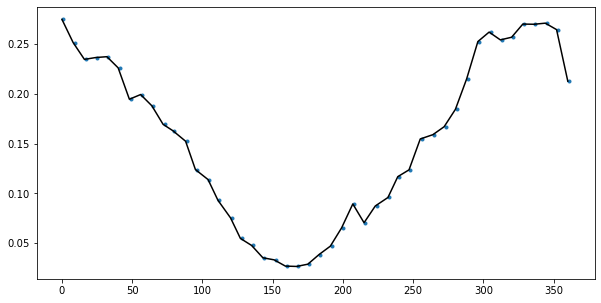

In [14]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(x['time.dayofyear'],x,marker='.',linestyle='none')
ax.plot(x_allyear,color='k')

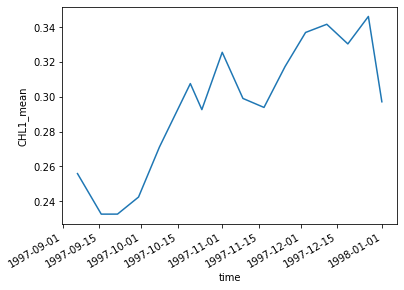

In [26]:
year = 1997
ds['CHL1_mean'].where(ds['CHL1_flags']==8,np.nan).sel({'time':slice(str(year)+'-01-01',str(year)+'-12-31')}).weighted(ds['area'].fillna(0)).mean(['lat','lon']).plot()

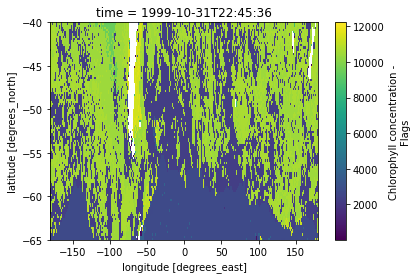

In [43]:
(ds['CHL1_flags'].where((ds['CHL1_flags']!=9) & (ds['CHL1_flags']!=1),np.nan)).isel(time=100).plot()

In [42]:
np.unique(ds['CHL1_flags'].isel(time=100))

array([1.0000e+00, 2.0000e+00, 9.0000e+00, 1.0000e+01, 6.5000e+01,
       6.6000e+01, 1.2900e+02, 1.3000e+02, 5.1300e+02, 5.2100e+02,
       5.7700e+02, 6.4100e+02, 1.2170e+03, 1.2180e+03, 1.7290e+03,
       2.0490e+03, 2.0500e+03, 2.1130e+03, 2.1140e+03, 2.1770e+03,
       2.1780e+03, 2.2410e+03, 2.2420e+03, 2.5610e+03, 2.6250e+03,
       2.6890e+03, 2.6900e+03, 2.7530e+03, 2.7540e+03, 3.0730e+03,
       3.0740e+03, 3.1370e+03, 3.1380e+03, 3.2010e+03, 3.2650e+03,
       3.2660e+03, 3.5850e+03, 3.6490e+03, 3.7130e+03, 3.7770e+03,
       8.1920e+03, 8.2000e+03, 8.2560e+03, 8.4480e+03, 8.4560e+03,
       8.5120e+03, 8.5760e+03, 8.9600e+03, 9.0880e+03, 9.4080e+03,
       9.6640e+03, 1.0240e+04, 1.0304e+04, 1.0368e+04, 1.0432e+04,
       1.0496e+04, 1.0560e+04, 1.0624e+04, 1.0688e+04, 1.0752e+04,
       1.0816e+04, 1.0880e+04, 1.0944e+04, 1.1008e+04, 1.1072e+04,
       1.1136e+04, 1.1200e+04, 1.1264e+04, 1.1328e+04, 1.1392e+04,
       1.1456e+04, 1.1520e+04, 1.1584e+04, 1.1648e+04, 1.1712e